<a href="https://colab.research.google.com/github/simon-smida/BP-Accuracy-Predictors/blob/main/lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Načtení souborů
V tomto skriptu se načtou log soubory uložené v ZIP souboru. Tento soubor si stáhněte a nahrajte do stejného adresáře, jakou jsou tyto jupyter notebooky. Jedná se o evoluční návrh 4bitových sčítaček pro různé parametry lambda, počet sloupců a četnost mutace.

In [1]:
! [ -e adders.zip ] || wget https://ehw.fit.vutbr.cz/bin/adders.zip
! [ -e example.log ] || wget https://ehw.fit.vutbr.cz/bin/example.log


--2024-03-22 15:47:10--  https://ehw.fit.vutbr.cz/bin/adders.zip
Resolving ehw.fit.vutbr.cz (ehw.fit.vutbr.cz)... 147.229.177.159, 2001:67c:1220:8b0::93e5:b19f
Connecting to ehw.fit.vutbr.cz (ehw.fit.vutbr.cz)|147.229.177.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8396621 (8.0M) [application/zip]
Saving to: ‘adders.zip’

adders.zip          100%[===================>]   8.01M  8.11MB/s    in 1.0s    

2024-03-22 15:47:12 (8.11 MB/s) - ‘adders.zip’ saved [8396621/8396621]

--2024-03-22 15:47:12--  https://ehw.fit.vutbr.cz/bin/example.log
Resolving ehw.fit.vutbr.cz (ehw.fit.vutbr.cz)... 147.229.177.159, 2001:67c:1220:8b0::93e5:b19f
Connecting to ehw.fit.vutbr.cz (ehw.fit.vutbr.cz)|147.229.177.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6153 (6.0K) [application/octet-stream]
Saving to: ‘example.log’

example.log         100%[===================>]   6.01K  --.-KB/s    in 0s      

2024-03-22 15:47:12 (1.49 GB/s) - ‘example

In [2]:
# Načtení potřebných knihoven
import zipfile
import pandas as pd
import re


V první funkci se pomocí regulárního výrazu naparsují vstupní parametry evoluce. Vytvoří se objekt typu `dictionary`.

In [3]:
def parse_filename(filename):
    # adders/FA-adder_full_u4bit-L1-C0050-M01-R0000.log
    g = re.match(r".*u(\d)bit-L(\d+)-C(\d+)-M(\d+)-R(\d+)\.log", filename)
    bw, lback, columns, mutations, run = g.groups()
    return {
        "bw": int(bw),
        "lambda_p": int(lback),
        "cols": int(columns),
        "muts": int(mutations),
        "run": int(run)
    }


parse_filename("adders/FA-adder_full_u4bit-L1-C0050-M01-R0000.log")


{'bw': 4, 'lambda_p': 1, 'cols': 50, 'muts': 1, 'run': 0}

Další funkce projde všechny řádky souboru a poslední řádek určující výslednou kvalitu se určí počet generací, doba trvání (v sekundách), zda se podařilo najít funkční řešení a celkový počet uzlů.

In [4]:
def parse_log(file):
    last_line = None
    # pruchod pres vsechny radky a hledani vystupu fitness
    # generation:         1 time: 0.000 idx:0 fitness: 1296/2560 active nodes: 26
    for l in file.readlines():
        if l.startswith("generation:"):
            last_line = l

    assert last_line

    g = re.match(
        r"generation:\s*(\d+) time:\s*(\d+\.\d+) idx:\d+ fitness: (\d+)/(\d+) active nodes: (\d+)", last_line)

    gen, time, fit, fitmax, active = g.groups()
    gen, fit, fitmax, active = int(gen), int(fit), int(fitmax), int(active)

    return {
        "gen": int(gen),
        "duration": float(time),
        "success": int(fit) >= int(fitmax),
        "nodes": int(active)
    }


print(parse_log(open("example.log", "r")))


{'gen': 1647531, 'duration': 48.027, 'success': True, 'nodes': 37}


Nyní se projodou všechny soubory a vytvoří se jeden slovník. Konstrukce `{**a, **b}` slouží ke spojení dvou slovníků.

In [5]:
from io import TextIOWrapper
alld = []
with zipfile.ZipFile("adders.zip") as zf:
    for filename in zf.namelist():
        if not filename.endswith(".log"):
            continue
        d = {"filename": filename}
        d = {**d, **parse_filename(filename)}
        # IO wrapper -> prevod z bytu na str
        d = {**d, **parse_log(TextIOWrapper(zf.open(filename, "r")))}

        alld.append(d)
alld


[{'filename': 'adders/FA-adder_full_u4bit-L1-C0050-M01-R0000.log',
  'bw': 4,
  'lambda_p': 1,
  'cols': 50,
  'muts': 1,
  'run': 0,
  'gen': 1647531,
  'duration': 48.027,
  'success': True,
  'nodes': 37},
 {'filename': 'adders/FA-adder_full_u4bit-L1-C0050-M01-R0001.log',
  'bw': 4,
  'lambda_p': 1,
  'cols': 50,
  'muts': 1,
  'run': 1,
  'gen': 9054341,
  'duration': 482.732,
  'success': True,
  'nodes': 36},
 {'filename': 'adders/FA-adder_full_u4bit-L1-C0050-M01-R0002.log',
  'bw': 4,
  'lambda_p': 1,
  'cols': 50,
  'muts': 1,
  'run': 2,
  'gen': 2323602,
  'duration': 127.441,
  'success': True,
  'nodes': 36},
 {'filename': 'adders/FA-adder_full_u4bit-L1-C0050-M01-R0003.log',
  'bw': 4,
  'lambda_p': 1,
  'cols': 50,
  'muts': 1,
  'run': 3,
  'gen': 1106003,
  'duration': 60.292,
  'success': True,
  'nodes': 33},
 {'filename': 'adders/FA-adder_full_u4bit-L1-C0050-M01-R0004.log',
  'bw': 4,
  'lambda_p': 1,
  'cols': 50,
  'muts': 1,
  'run': 4,
  'gen': 3538888,
  'duratio

Nyní se vytvoří z pole slovníků jeden dataframe (tabulka), se kterou budeme dále pracovat.

In [6]:
df = pd.DataFrame(alld)
df


,filename,bw,lambda_p,cols,muts,run,gen,duration,success,nodes
0,adders/FA-adder_full_u4bit-L1-C0050-M01-R0000.log,4,1,50,1,0,1647531,48.027,True,37
1,adders/FA-adder_full_u4bit-L1-C0050-M01-R0001.log,4,1,50,1,1,9054341,482.732,True,36
2,adders/FA-adder_full_u4bit-L1-C0050-M01-R0002.log,4,1,50,1,2,2323602,127.441,True,36
3,adders/FA-adder_full_u4bit-L1-C0050-M01-R0003.log,4,1,50,1,3,1106003,60.292,True,33
4,adders/FA-adder_full_u4bit-L1-C0050-M01-R0004.log,4,1,50,1,4,3538888,181.252,True,36
...,...,...,...,...,...,...,...,...,...,...
2155,adders/FA-adder_full_u4bit-L4-C0500-M20-R0085.log,4,4,500,20,85,433493,113.220,True,84
2156,adders/FA-adder_full_u4bit-L4-C0500-M20-R0086.log,4,4,500,20,86,361864,63.896,True,60
2157,adders/FA-adder_full_u4bit-L4-C0500-M20-R0087.log,4,4,500,20,87,416746,71.737,True,89
2158,adders/FA-adder_full_u4bit-L4-C0500-M20-R0088.log,4,4,500,20,88,271578,71.305,True,64


S tabulkou můžeme dále pracovat - např. si určit úspěšnost návrhu.

In [7]:
df["success"].mean()


1.0

A data si uložíme do Pickle souboru pro další zpracování.

In [8]:
df.to_pickle("data.pkl.gz")


# Zpracování dat
Tento notebook představuje hlavní část, se kterou budete ve svém řešení projektu pracovat. Načtou se data, která jste vygenerovali v části 1 a budete je dále analyzovat. Normálně by toto byl samostatný soubor, nicméně pro práci s Google Colab je lepší pracovat s jedním notebookem

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np


Pomocí funkce `pd.read_pickle` načtěte soubor _data.pkl.gz_. Tento soubor uložte do proměnné `df` a zobrazte ji jako tabulku (tj. poslední řádek buňky bude `df`).

In [10]:
# TODO
df = pd.read_pickle("data.pkl.gz")
df

,filename,bw,lambda_p,cols,muts,run,gen,duration,success,nodes
0,adders/FA-adder_full_u4bit-L1-C0050-M01-R0000.log,4,1,50,1,0,1647531,48.027,True,37
1,adders/FA-adder_full_u4bit-L1-C0050-M01-R0001.log,4,1,50,1,1,9054341,482.732,True,36
2,adders/FA-adder_full_u4bit-L1-C0050-M01-R0002.log,4,1,50,1,2,2323602,127.441,True,36
3,adders/FA-adder_full_u4bit-L1-C0050-M01-R0003.log,4,1,50,1,3,1106003,60.292,True,33
4,adders/FA-adder_full_u4bit-L1-C0050-M01-R0004.log,4,1,50,1,4,3538888,181.252,True,36
...,...,...,...,...,...,...,...,...,...,...
2155,adders/FA-adder_full_u4bit-L4-C0500-M20-R0085.log,4,4,500,20,85,433493,113.220,True,84
2156,adders/FA-adder_full_u4bit-L4-C0500-M20-R0086.log,4,4,500,20,86,361864,63.896,True,60
2157,adders/FA-adder_full_u4bit-L4-C0500-M20-R0087.log,4,4,500,20,87,416746,71.737,True,89
2158,adders/FA-adder_full_u4bit-L4-C0500-M20-R0088.log,4,4,500,20,88,271578,71.305,True,64


Pomocí funkce `unique()` vázané k sérii (sloupci) vypište unikátní hodnoty slouců _cols, muts, lambda_p_.

In [11]:
# TODO
print(f"cols: {df['cols'].unique()}")
print(f"muts: {df['muts'].unique()}")
print(f"lambda_p: {df['lambda_p'].unique()}")

cols: [ 50 100 500]
muts: [ 1  5 10 20]
lambda_p: [1 4]


## Jednoduchá analýza výsledků
Pomocí filtrace `df.query` vytvořte nový dataframe `df2`, který bude obsahovat pouze výsledky s 5 mutacemi a parametrem _lambda_p_ roven 1 a s úspěšnými hledáními (_success_ je pozitivní). Tento dataframe rovnou zobrazte.

In [12]:
# TODO
df2 = df.query("muts == 5 and lambda_p == 1 and success==True")
df2


,filename,bw,lambda_p,cols,muts,run,gen,duration,success,nodes
90,adders/FA-adder_full_u4bit-L1-C0050-M05-R0000.log,4,1,50,5,0,16049771,410.215,True,37
91,adders/FA-adder_full_u4bit-L1-C0050-M05-R0001.log,4,1,50,5,1,16110669,384.738,True,40
92,adders/FA-adder_full_u4bit-L1-C0050-M05-R0002.log,4,1,50,5,2,4668996,212.050,True,40
93,adders/FA-adder_full_u4bit-L1-C0050-M05-R0003.log,4,1,50,5,3,2541158,113.824,True,37
94,adders/FA-adder_full_u4bit-L1-C0050-M05-R0004.log,4,1,50,5,4,6812178,303.183,True,33
...,...,...,...,...,...,...,...,...,...,...
895,adders/FA-adder_full_u4bit-L1-C0500-M05-R0085.log,4,1,500,5,85,3860603,339.157,True,52
896,adders/FA-adder_full_u4bit-L1-C0500-M05-R0086.log,4,1,500,5,86,1774823,98.425,True,61
897,adders/FA-adder_full_u4bit-L1-C0500-M05-R0087.log,4,1,500,5,87,765902,67.331,True,58
898,adders/FA-adder_full_u4bit-L1-C0500-M05-R0088.log,4,1,500,5,88,1819540,100.595,True,64


## Tvorba boxplotu
Vytvořte jednoduchý boxplot pro dobu trvání (sloupec _duration_) pro jednotlivé nastavení počtu sloupců (_cols_). Pro data pro každý ze tří boxplotů můžete použtí filtraci z `df2` příkazem `query`, ze kterého pak vyberete pouze duration - t.j. `df2.query("...")["duration]`. Nezapomeňte nastavit popisky os a ticky na ose X.

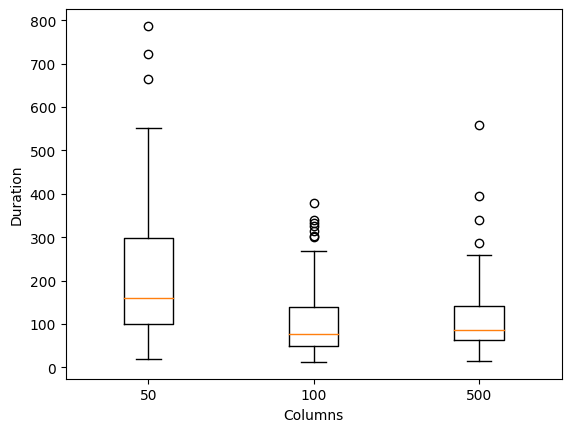

In [13]:
# TODO
dfcol50 = df2.query("cols == 50")["duration"]
dfcol100 = df2.query("cols == 100")["duration"]
dfcol500 = df2.query("cols == 500")["duration"]
plt.boxplot([dfcol50, dfcol100, dfcol500])
plt.xticks([1, 2, 3], ["50", "100", "500"])
plt.xlabel("Columns")
plt.ylabel("Duration")
plt.show()

Do tohoto pole napište závěr z boxplotu. Co můžeme vidět? (cca 2 věty)

## Tvorba histogramu
Nyní si zanalyzujeme výsledky trvání pro __50 sloupců__ detailně. Vykreslete proto histogram pro toto nastavení. Použijte filtraci jako výše.

Graf nezapomeňte správně nakonfigurovat (titulek, popisy os, limit a podobně)

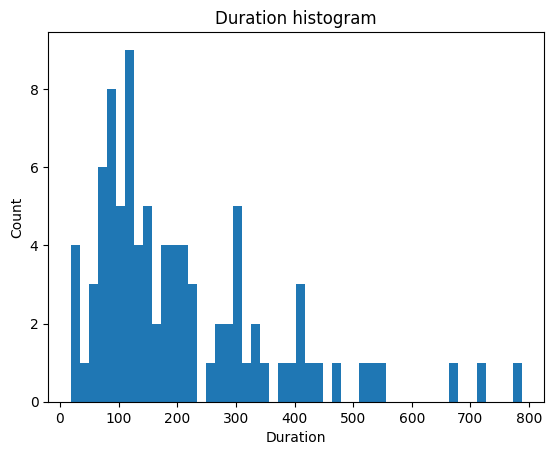

In [14]:
# TODO
plt.hist(dfcol50, bins=50)
plt.title("Duration histogram")
plt.xlabel("Duration")
plt.ylabel("Count")
plt.show()

## Statistická analýza
Jaká je průměrná doba trvání pro 100 a 500 sloupců? Vytvořte si dvě série výběrem jako výše a vypište jejich: průměr, medián, minimum, maximum a 1. a 3. kvartil.

In [15]:
# TODO
print("100 columns")
print(dfcol100.describe())

print()

print("500 columns")
print(dfcol500.describe())

100 columns
count     90.000000
mean     108.079478
std       86.726435
min       12.350000
25%       48.508000
50%       75.820500
75%      140.089750
max      378.526000
Name: duration, dtype: float64

500 columns
count     90.000000
mean     112.068511
std       84.413037
min       14.618000
25%       62.187250
50%       86.562000
75%      142.285250
max      557.963000
Name: duration, dtype: float64


Podle mediánů se ukázalo, že jedno řešení je lepší. Je to opravdu statisticky významné? Proveďte [Mann-Whitney U-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) (`mannwhitneyu`), protože data nejsou normální. Určete, zda je tento rozdíl signifikantní (s věrností 0.95).

> The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

In [16]:
# TODO
stat, p = st.mannwhitneyu(dfcol100, dfcol500)
print("p-value:", p)
print("stat:", stat)
# Hypotéza H0: Columns 100 a 500 majú podobné (rovnaké) p. rozloženie
# p-value: 0.29703499575193637
if p < 0.05:
    print("Zamietame nulovu hypotezu - rozdiel medzi 100 a 500 columns je signifikantny")
else:
    print("Nepodarilo sa zamietnut nulovu hypotezu - rozdiel medzi 100 a 500 columns nie je signifikantny")

p-value: 0.29703499575193637
stat: 3685.0
Nepodarilo sa zamietnut nulovu hypotezu - rozdiel medzi 100 a 500 columns nie je signifikantny


Napište závěr analýzy

## Pro rychlé a zvídavé
Tento notebook představuje rychlokurz datové analýzy a nepředstavuje vždy nejlepší řešení. Zkuste si pak implementovat boxploty pomocí Seabornu (`sns.boxplot`), kdy vyplníte parametry `data` (dataframe), `x` (název sloupce na x-ové ose) a `y` (název sloupce na ose y). Navíc můžete použít i větší dataset a nastavit parametr `hue` pro podbarvení (např. počet mutací). Návratová hodnota je matplotib _axis_ (`ax`), který můžete použít k další konfiguraci

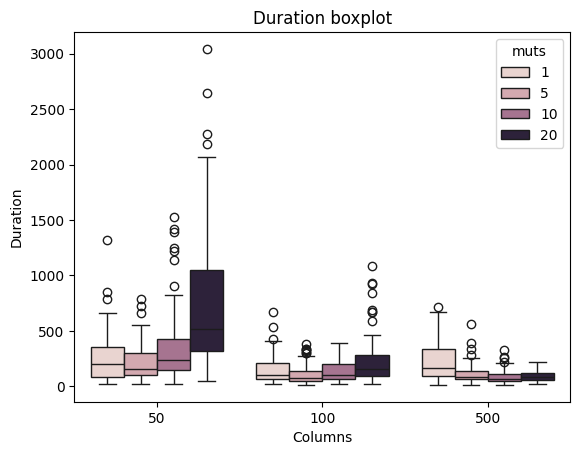

In [17]:
import seaborn as sns
# ax = sns.boxplot(data=df.query("success and lback==1"), ...) # todo (jen ve volném čase)
ax = sns.boxplot(data=df.query("success and lambda_p==1"), x="cols", y="duration", hue="muts")
ax.set_title("Duration boxplot")
ax.set_xlabel("Columns")
ax.set_ylabel("Duration")
plt.show()


# Konvergenční křivky
Pro vybranou konfiguraci (s 90 běhy) nás bude zajímat, jak vlastně vypadá vývoj fitness v čase. Zase by se jednalo o samostatný soubor, ale kvůli Google Colab stále pracujeme v jednom notebooku.

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import re


## Získávání dat
Nyní chceme převést každý log do 2D numpy pole, kdy první první sloupec obsahuje generaci a druhý sloupec odpovídající fitness. Vaším úkolem bude doplnit regulární výraz pro načítání generace a fitness a po dvojicích jej vložit do pole `alld`. Pro testovací log soubor by měl vzniknout následující výstup:

```[[      1    1296]
 [     12    1352]
 [     26    1392]
...
 [1589571    2536]
 [1647531    2560]]```


In [19]:
# TODO
def parse_gens(file): ###
    # pruchod pres vsechny radky a hledani vystupu fitness ###
    # generation:         1 time: 0.000 idx:0 fitness: 1296/2560 active nodes: 26 ###
    alld = [] ###
    for l in file.readlines(): ###
        # napiste vhodny regularni vyrat podle sablony nahore ziskavajici  dvojici generace a fitness ###
        # z tohoto udelame 2d numpy pole (staci pridat do pole alld) ###
        # alld.append([ int(gen), int(fit)]) ###
        result = re.match(r"generation:\s*(\d+).*fitness:\s*(\d+).*", l)
        if result:
            gen, fit = result.groups()
            alld.append([int(gen), int(fit)])
###
    return np.array(alld)  ###
print(parse_gens(open("example.log", "r"))) ###


[[      1    1296]
 [     12    1352]
 [     26    1392]
 [     55    1404]
 [    318    1436]
 [    334    1492]
 [    566    1524]
 [    583    1536]
 [    882    1664]
 [   1096    1696]
 [   1692    1712]
 [   2166    1728]
 [   3738    1744]
 [   3741    1760]
 [   3804    1792]
 [   8518    1808]
 [   8531    1840]
 [   8550    1888]
 [   8938    1920]
 [   9537    1936]
 [   9538    1952]
 [  11996    1984]
 [  19818    1992]
 [  19825    2000]
 [  20545    2008]
 [  20578    2016]
 [  20630    2024]
 [  20670    2040]
 [  21323    2048]
 [  21416    2080]
 [  21649    2112]
 [  28001    2120]
 [  28284    2128]
 [  28791    2144]
 [  31935    2176]
 [  88212    2192]
 [  89609    2208]
 [ 125401    2224]
 [ 125607    2240]
 [ 186461    2272]
 [ 186725    2288]
 [ 188051    2304]
 [ 193849    2336]
 [ 194146    2368]
 [ 202584    2376]
 [ 259842    2380]
 [ 267481    2392]
 [ 498071    2400]
 [ 536514    2408]
 [ 536559    2416]
 [ 537754    2432]
 [ 606305    2440]
 [ 608640   

Nyní vytvoříme list numpy 2D polí (pro každý log soubor) odpovídající nastavení _bw=4, lambda=1, cols=50 a muts=5_ (vybráno náhodně). Nemohli jsme udělat jedno 3D pole, jelikož každé hledání vyžaduje jiný počet kroků - třetí dimenze pak není konstantní.

In [20]:
from io import TextIOWrapper
allgens = []

alld = []
with zipfile.ZipFile("adders.zip") as zf:
    for filename in zf.namelist():
        if not filename.endswith(".log") or "FA-adder_full_u4bit-L1-C0050-M05-R" not in filename:
            continue
        # IO wrapper -> prevod z bytu na str
        gens = parse_gens(TextIOWrapper(zf.open(filename, "r")))

        allgens.append(gens)
allgens


[array([[       2,     1296],
        [       3,     1344],
        [      26,     1352],
        [      29,     1400],
        [      37,     1408],
        [      60,     1418],
        [     110,     1420],
        [     122,     1422],
        [     133,     1440],
        [     270,     1448],
        [     322,     1472],
        [     582,     1536],
        [    1406,     1552],
        [    1414,     1560],
        [    1582,     1568],
        [    1721,     1584],
        [    1784,     1600],
        [    1863,     1632],
        [    1919,     1696],
        [    1959,     1760],
        [    2256,     1792],
        [    2294,     1856],
        [    3685,     1888],
        [    3840,     1920],
        [    4076,     1936],
        [    4119,     1984],
        [    5362,     2048],
        [   30800,     2080],
        [   32885,     2112],
        [   34993,     2176],
        [  124566,     2188],
        [  124585,     2196],
        [  124818,     2200],
        [ 

## Všechny křivky přes sebe
Vykreslete graf všech běhů. Pro každý běh `for g in allgens` vykreslete jednu čáru - ideálně použijte funkci `ax.step(x = ..., y = ...  ,where="post", alpha = 0.2)`. Alfa kanál umožní zobrazení více čar přes sebe. Výběr všech generací z dvoudimenzionálního pole `g` (první sloupec v první dimenzi) je možné provést jako `g[:, 0]`. Všechny hodnoty fitness budou `g[:, 1]`.

Grafu nastavte logaritmické měřítko na ose X.

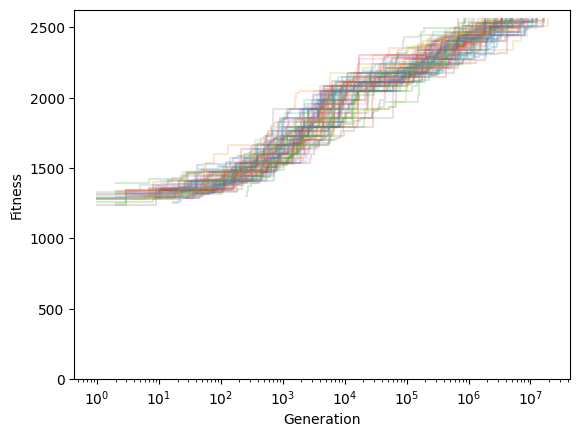

In [22]:
# TODO
fig, ax = plt.subplots() ###
##
for g in allgens: ###
    ax.step(g[:, 0], g[:, 1], where="post", alpha=0.2)
    # vykreslete pomoci ax.step ###
# nastavte parametry (log. meritko, ylim od 0 do None, popisky os, ...)
ax.set_xscale("log") ###
ax.set_ylim(0, None) ###
ax.set_xlabel("Generation") ###
ax.set_ylabel("Fitness") ###
plt.show() ###


Tato konvergenční křivka sice trochu pomůže, ale není to správná vizualizace tohoto děje.

## Vykreslení konvergenční křivky
Mohli bychom si spočítat minimum, maximum a průměr a vykreslit pomocí `plt.fill_between`, ale pro nás je výhodnější využít knihovnu _seaborn_. Tato knihovna umožňuje jednoduše generovat grafy z Pandas dataframu. Výhodou je to, že je pak můžeme upravit s využitím našich znalostí z matplotlib. Pro více ukázek doporučuji zkontrolovat [galerii](https://seaborn.pydata.org/examples/index.html).

V první části převedeme všechna data na jeden dataframe, kde přidáme sloupec "runid".

In [23]:
alldf = []

for rid, g in enumerate(allgens):
    d = pd.DataFrame(g, columns=["gen", "fit"])
    d["runid"] = rid
    alldf.append(d)
df = pd.concat(alldf, ignore_index=True)
df


,gen,fit,runid
0,2,1296,0
1,3,1344,0
2,26,1352,0
3,29,1400,0
4,37,1408,0
...,...,...,...
5058,6846197,2480,89
5059,6859680,2496,89
5060,6890691,2512,89
5061,6999771,2536,89


Vykreslete nyní čárový graf pomocí funkce `sns.lineplot`. Argumenty budou `data=df, x="gen", y="fit"`.

Návratová hodnota této funkce je objekt _Axis_ `ax`. Nastavte mu stejné parametry, jako výše (logaritmické měřítko a podobně).

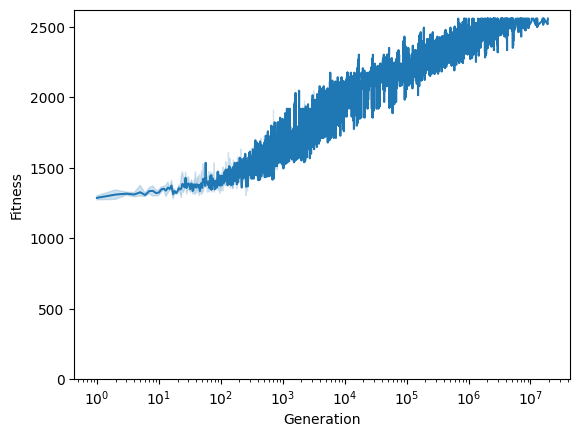

In [24]:
# TODO
ax = sns.lineplot(data=df, x="gen", y="fit")
ax.set_xscale("log")
ax.set_ylim(0, None)
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
plt.show()


Tento graf ale není správně. Správně se měl spočítat tzv. confidence interval a mělo být vidět, jak se fitness mění v čase. Problémem je to, že nemáme pro každou generaci definovaný výsledek pro všechny běhy. Nezbývá určit vzorkovací body, pro které si spočítáme (interpolujeme) hodnotu fitness.

Vytvořte tedy numpy pole `gens_selected` obsahující logaritmicky vzorkované body. Pro generování tohoto rozsahu můžete využít funkci `np.geomspace(start, stop, steps)` s tím, že zvolíte na základě předchozího grafu počátek, konec a vhodný počet bodů.

In [29]:
# TODO
gens_selected = np.geomspace(1, 10e8, 100)
gens_selected

array([1.00000000e+00, 1.23284674e+00, 1.51991108e+00, 1.87381742e+00,
       2.31012970e+00, 2.84803587e+00, 3.51119173e+00, 4.32876128e+00,
       5.33669923e+00, 6.57933225e+00, 8.11130831e+00, 1.00000000e+01,
       1.23284674e+01, 1.51991108e+01, 1.87381742e+01, 2.31012970e+01,
       2.84803587e+01, 3.51119173e+01, 4.32876128e+01, 5.33669923e+01,
       6.57933225e+01, 8.11130831e+01, 1.00000000e+02, 1.23284674e+02,
       1.51991108e+02, 1.87381742e+02, 2.31012970e+02, 2.84803587e+02,
       3.51119173e+02, 4.32876128e+02, 5.33669923e+02, 6.57933225e+02,
       8.11130831e+02, 1.00000000e+03, 1.23284674e+03, 1.51991108e+03,
       1.87381742e+03, 2.31012970e+03, 2.84803587e+03, 3.51119173e+03,
       4.32876128e+03, 5.33669923e+03, 6.57933225e+03, 8.11130831e+03,
       1.00000000e+04, 1.23284674e+04, 1.51991108e+04, 1.87381742e+04,
       2.31012970e+04, 2.84803587e+04, 3.51119173e+04, 4.32876128e+04,
       5.33669923e+04, 6.57933225e+04, 8.11130831e+04, 1.00000000e+05,
      

Nyní budeme interpolovat a extrapolovat. Využijeme k tomu funkci `scipy.interpolate.interp1d`. Tato funkce vytváří objekt na základě dvojic _x_ a _y_. Potom tento objekt můžeme zavolat (jako funkci) s libovolným vstupem (i vektorem) a vrátí nám body, které by fitness měla pro danou generaci. Normálně se dělá lineární proložení, nicméně zde budeme prokládat předchozí hodnotou (fitness se mění skokově).

Vyzkoušejte si funkci `interp1d` a vytvořte si objekt `f` pro jeden běh. Zavolejte tento objekt s vektorem `x2`. Vykreslete si

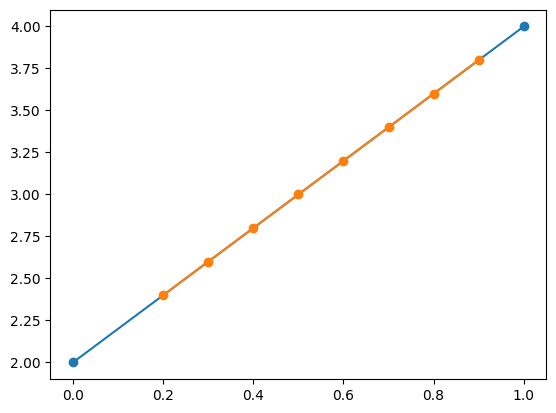

In [30]:
x = [0, 1] ###
y = [2, 4] ###
x2 = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # tyto body nas zajimaji ###
plt.plot(x, y, "o-") ###
from scipy.interpolate import interp1d ###
# todo vytvorte y2 jako linearni interpolaci y v bodech x2 ###
# todo vykreslete si body x2, y2 ###
f = interp1d(x, y)
y2 = f(x2) ###
plt.plot(x2, y2, "o-") ###
plt.show() ###

Stejně tak to uděláme i pro všechny běhy. Všiměte si, že používáme interpolaci _previous_, která nám vrátí poslední známou hodnotu. A můžeme jít i "za konec" - extrapolovat.

In [31]:
from scipy.interpolate import interp1d
alldf = []

for rid, g in enumerate(allgens):
    # vytvorime interpolacni funkci. Pridame i bod 0, protoze ten v seznamu neni
    g = np.concatenate([[[0, g[0, 1]]], g])
    fn = interp1d(x=g[:, 0], y=g[:, 1], kind="previous",
                  fill_value="extrapolate")

    d = pd.DataFrame()
    # generace nastavime nasim vzorkovacim
    d["gen"] = gens_selected
    # a fitness odpovida prolozene hodnote
    d["fit"] = fn(gens_selected)
    d["runid"] = rid
    alldf.append(d)
df_interp = pd.concat(alldf, ignore_index=True)
df_interp


,gen,fit,runid
0,1.000000e+00,1296.0,0
1,1.232847e+00,1296.0,0
2,1.519911e+00,1296.0,0
3,1.873817e+00,1296.0,0
4,2.310130e+00,1296.0,0
...,...,...,...
8995,4.328761e+08,2560.0,89
8996,5.336699e+08,2560.0,89
8997,6.579332e+08,2560.0,89
8998,8.111308e+08,2560.0,89


Nyní vykreslete graf stejně jako výše pomocí finkce `sns.lineplot`. Použijte funkci úplně stejně jako výše, jen místo `df` použijte naše nová vzrokovaná data `df_interp`.

Vykreslil se už graf správně? Všimněte si, kde docházelo k variacím a kde už je velká jistota, že fitness bude vysoká. Je zadaný algoritmus stabilní z pohledu konvergence?

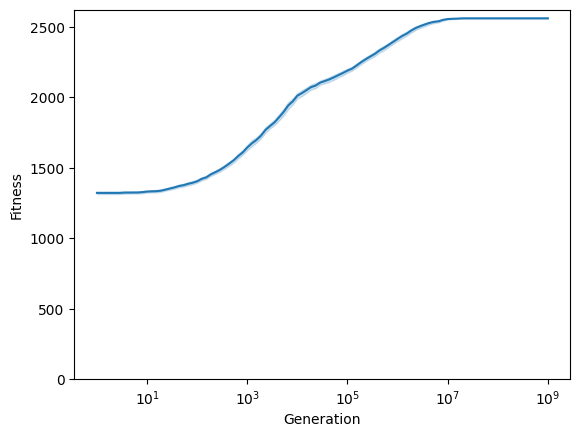

In [32]:
# TODO
ax = sns.lineplot(data=df_interp, x="gen", y="fit")
ax.set_xscale("log")
ax.set_ylim(0, None)
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
plt.show()

Barevný pruh nám určuje confidence interval (0.95) počítaný z distribuce. Střed je průměrná hodnota. My si však můžeme zobrazit např medián a minimum a maximum. Více v [dokumentaci](https://seaborn.pydata.org/tutorial/error_bars.html)

Zkuste přidat parametr `estimator="median", errorbar=("pi", 100)` (100. percentil - min / max, můžete použít třeba 75.).

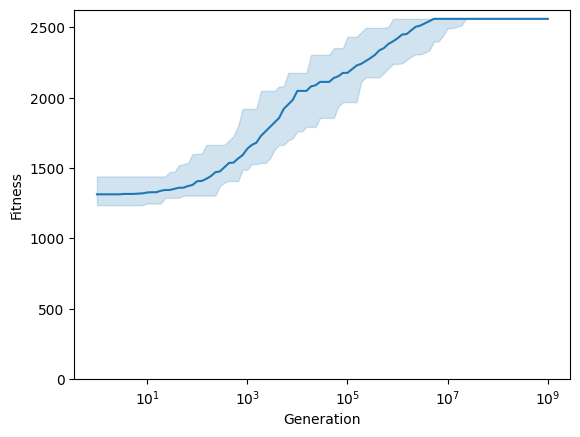

In [33]:
# TODO
ax = sns.lineplot(data=df_interp, x="gen", y="fit", estimator="median", errorbar=("pi", 100))
ax.set_xscale("log")
ax.set_ylim(0, None)
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
plt.show()